In [1]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# For image manipulation
import cv2
import imutils

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras import layers
from keras import models

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

In [2]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'

X_train = []
y_train = []

for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

X_train, y_train = shuffle(X_train, y_train)

tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0375.jpg,glioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0435.jpg,meningioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0583.jpg,meningioma
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0830.jpg,notumor
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1122.jpg,notumor
...,...,...
5707,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1315.jpg,notumor
5708,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/pituitary/Tr-pi_0887.jpg,pituitary
5709,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0945.jpg,meningioma
5710,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_0999.jpg,notumor


## Exploratory Data Analysis

In [3]:
tumor_train_df.shape

(5712, 2)

In [4]:
tumor_train_df['label'].value_counts(normalize = True)

notumor       0.279237
pituitary     0.255077
meningioma    0.234419
glioma        0.231268
Name: label, dtype: float64

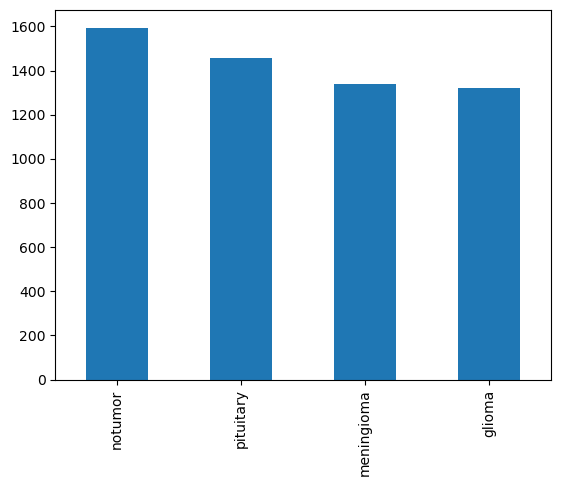

In [5]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [6]:
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

X_test = []
y_test = []

for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

X_test, y_test = shuffle(X_test, y_test)

tumor_test_df = pd.concat([pd.Series(X_test, name = 'images'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,images,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0277.jpg,glioma
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0191.jpg,notumor
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0141.jpg,notumor
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0089.jpg,pituitary
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0023.jpg,pituitary
...,...,...
1306,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0125.jpg,notumor
1307,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0040.jpg,pituitary
1308,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0211.jpg,notumor
1309,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0103.jpg,pituitary


In [7]:
tumor_test_df['label'].value_counts(normalize = True)

notumor       0.308924
meningioma    0.233410
glioma        0.228833
pituitary     0.228833
Name: label, dtype: float64

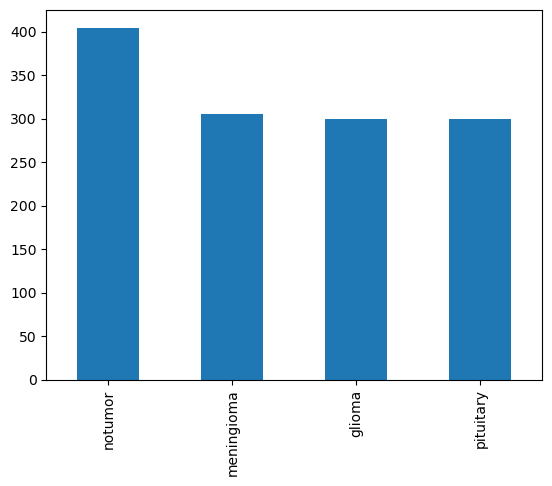

In [8]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

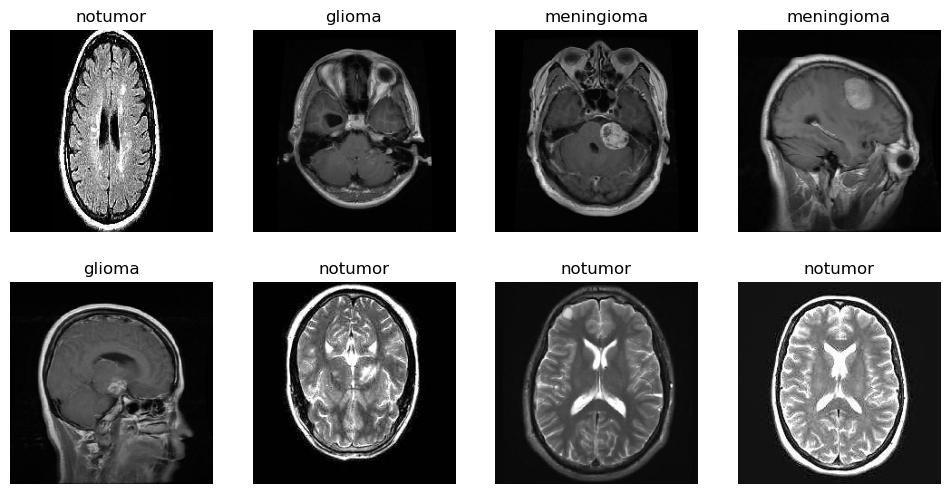

In [9]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)
batch_size = 32

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

images = open_images(X_train[50:59])
labels = y_train[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Baseline Model

In [10]:
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)

train_generator_baseline = train_datagen_baseline.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

test_generator_baseline = test_datagen_baseline.flow_from_directory(
        test_dir,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [11]:
reg = l2(3e-3)
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
callback = EarlyStopping(monitor='loss', patience=2)

model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=30,
                       callbacks = [callback])

Metal device set to: Apple M1 Pro
Epoch 1/30


2023-04-06 11:21:27.063462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-06 11:21:27.063593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-06 11:21:27.242904: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  1/179 [..............................] - ETA: 51s - loss: 1.4571 - accuracy: 0.1250

2023-04-06 11:21:27.398205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


179/179 [==============================] - ETA: 0s - loss: 1.1383 - accuracy: 0.6425

2023-04-06 11:21:35.229510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


179/179 [==============================] - 9s 50ms/step - loss: 1.1383 - accuracy: 0.6425 - val_loss: 0.7484 - val_accuracy: 0.7117
Epoch 2/30
179/179 [==============================] - 8s 43ms/step - loss: 0.6247 - accuracy: 0.7644 - val_loss: 0.6424 - val_accuracy: 0.7834
Epoch 3/30
179/179 [==============================] - 8s 43ms/step - loss: 0.5108 - accuracy: 0.8255 - val_loss: 0.7493 - val_accuracy: 0.7315
Epoch 4/30
179/179 [==============================] - 8s 43ms/step - loss: 0.4514 - accuracy: 0.8353 - val_loss: 0.5682 - val_accuracy: 0.8070
Epoch 5/30
179/179 [==============================] - 8s 44ms/step - loss: 0.3830 - accuracy: 0.8662 - val_loss: 0.5524 - val_accuracy: 0.8169
Epoch 6/30
179/179 [==============================] - 8s 44ms/step - loss: 0.3231 - accuracy: 0.8901 - val_loss: 0.4771 - val_accuracy: 0.8314
Epoch 7/30
179/179 [==============================] - 8s 44ms/step - loss: 0.3069 - accuracy: 0.8948 - val_loss: 0.4426 - val_accuracy: 0.8535
Epoch 8/30

In [12]:
# # with gratitude to Ruslan Klymentiev for this function and the two cells below
# # https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
# # and Adrian Rosebrock from pyimagesearch for the underlying concept
# # https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)

In [13]:
# img = cv2.imread(train_paths[58])
# img = cv2.resize(
#             img,
#             dsize=IMAGE_SIZE,
#             interpolation=cv2.INTER_CUBIC
#         )
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)

# # threshold the image, then perform a series of erosions +
# # dilations to remove any small regions of noise
# thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# thresh = cv2.erode(thresh, None, iterations=2)
# thresh = cv2.dilate(thresh, None, iterations=2)

# # find contours in thresholded image, then grab the largest one
# cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts = imutils.grab_contours(cnts)
# c = max(cnts, key=cv2.contourArea)

# # find the extreme points
# extLeft = tuple(c[c[:, :, 0].argmin()][0])
# extRight = tuple(c[c[:, :, 0].argmax()][0])
# extTop = tuple(c[c[:, :, 1].argmin()][0])
# extBot = tuple(c[c[:, :, 1].argmax()][0])

# # add contour on the image
# img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# # add extreme points
# img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
# img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
# img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
# img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# # crop
# new_img = img[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

In [14]:
# fig, axes = plt.subplots(ncols = 4, figsize=(15,6))
# axes[0].axis('off')
# axes[1].axis('off')
# axes[2].axis('off')
# axes[3].axis('off')

# axes[0].imshow(img)
# axes[0].set_title('Step 1. Get the original image')
# axes[1].imshow(img_cnt)
# axes[1].set_title('Step 2. Find the biggest contour')
# axes[2].imshow(img_pnt)
# axes[2].set_title('Step 3. Find the extreme points')
# axes[3].imshow(new_img)
# axes[3].set_title('Step 4. Crop the image')

# plt.tight_layout()
# plt.show()